In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace
import math
import pickle
from google.colab import drive
import os
import matplotlib.pyplot as plt
from datasets import load_dataset
import random
from tqdm import tqdm

In [15]:
# ============================================================================
# DATASET LOADING
# ============================================================================

def load_arxiv_huggingface(num_samples=10000):
    """Load ML ArXiv papers from Hugging Face."""
    print("=" * 60)
    print("LOADING ARXIV DATASET FROM HUGGING FACE")
    print("=" * 60)
    print(f"Dataset: CShorten/ML-ArXiv-Papers")
    print(f"Target samples: {num_samples}\n")

    try:
        print("Downloading dataset...")
        dataset = load_dataset("CShorten/ML-ArXiv-Papers", split="train")
        print(f"✓ Dataset loaded: {len(dataset)} papers available")

        abstracts = []
        for i, paper in enumerate(dataset):
            if len(abstracts) >= num_samples:
                break

            abstract = paper['abstract'].strip()

            # Filter: reasonable length abstracts
            if 100 < len(abstract) < 5000:
                abstract = ' '.join(abstract.split())
                abstracts.append(abstract)

        print(f"✓ Extracted {len(abstracts)} quality abstracts")
        print(f"✓ Average length: {sum(len(a.split()) for a in abstracts) / len(abstracts):.1f} words")
        print("=" * 60)

        return abstracts

    except Exception as e:
        print(f"✗ Error loading dataset: {e}")
        print("\nFalling back to synthetic generation...")
        return generate_synthetic_abstracts(num_samples)


def generate_synthetic_abstracts(num_samples=1000):
    """Generate synthetic academic abstracts as fallback."""
    print("\n⚠ Generating synthetic abstracts as fallback")

    templates = [
        "We present a novel approach to {topic} using {method}. "
        "Our experiments demonstrate that {result}. "
        "The proposed framework {contribution} and achieves {performance}. "
        "We analyze the {analysis} and provide {insights}. "
        "Experimental results on {datasets} show that our method {comparison}.",

        "This paper introduces a new method for {topic} based on {method}. "
        "The key innovation is {innovation}. "
        "We evaluate our approach on {datasets} and show that {result}. "
        "Compared to existing methods, our approach {comparison}. "
        "The main contributions include {contribution}.",

        "In this work, we propose {method} for {topic}. "
        "Our method {advantage} while {constraint}. "
        "We demonstrate {result} through extensive experiments on {datasets}. "
        "The results show that {performance}. "
        "We also provide {analysis} of {insights}.",
    ]

    components = {
        'topic': ["machine learning", "deep neural networks", "natural language processing",
                 "computer vision", "reinforcement learning", "optimization algorithms"],
        'method': ["transformer architectures", "self-supervised learning", "contrastive learning",
                  "adversarial training", "multi-task learning", "few-shot learning"],
        'result': ["significant improvements", "state-of-the-art performance", "competitive results"],
        'contribution': ["combines multiple techniques", "introduces a novel loss function",
                        "provides theoretical guarantees"],
        'performance': ["10% improvement in accuracy", "better sample efficiency", "superior generalization"],
        'datasets': ["standard benchmarks", "multiple datasets", "real-world scenarios"],
        'comparison': ["outperforms previous methods", "achieves comparable results", "demonstrates robustness"],
        'analysis': ["model behavior", "learned representations", "convergence properties"],
        'insights': ["theoretical justification", "practical guidelines", "design principles"],
        'innovation': ["a new architecture design", "an improved training procedure", "a novel technique"],
        'advantage': ["improves accuracy", "reduces computational cost", "enhances interpretability"],
        'constraint': ["maintaining efficiency", "preserving simplicity", "ensuring stability"]
    }

    abstracts = []
    for _ in range(num_samples):
        template = random.choice(templates)
        kwargs = {k: random.choice(v) for k, v in components.items()}
        abstracts.append(template.format(**kwargs))

    print(f"✓ Generated {len(abstracts)} synthetic abstracts")
    return abstracts

In [16]:

# ============================================================================
# DATASET CLASS
# ============================================================================

class ArXivDataset(Dataset):
    """Dataset for arXiv abstracts with tokenization and padding."""

    def __init__(self, abstracts, tokenizer, max_len=256):
        self.abstracts = abstracts
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.bos_id = tokenizer.token_to_id("[BOS]")
        self.eos_id = tokenizer.token_to_id("[EOS]")
        self.pad_id = tokenizer.token_to_id("[PAD]")

    def __len__(self):
        return len(self.abstracts)

    def __getitem__(self, idx):
        text = self.abstracts[idx]
        encoding = self.tokenizer.encode(text)
        tokens = encoding.ids

        if len(tokens) > self.max_len - 2:
            tokens = tokens[:self.max_len - 2]

        tokens = [self.bos_id] + tokens + [self.eos_id]
        input_seq = tokens[:-1]
        target_seq = tokens[1:]

        pad_len = self.max_len - len(input_seq)
        input_seq = input_seq + [self.pad_id] * pad_len
        target_seq = target_seq + [self.pad_id] * pad_len

        return {
            'input_ids': torch.tensor(input_seq, dtype=torch.long),
            'target_ids': torch.tensor(target_seq, dtype=torch.long),
            'attention_mask': torch.tensor([1 if t != self.pad_id else 0 for t in input_seq], dtype=torch.long)
        }


def build_tokenizer(abstracts, vocab_size=8000):
    """Train WordPiece tokenizer from scratch."""
    tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = Whitespace()

    trainer = WordPieceTrainer(
        vocab_size=vocab_size,
        special_tokens=["[PAD]", "[BOS]", "[EOS]", "[UNK]"]
    )

    tokenizer.train_from_iterator(abstracts, trainer)
    return tokenizer


In [17]:

# ============================================================================
# MODEL COMPONENTS
# ============================================================================

class SinusoidalPositionalEncoding(nn.Module):
    """Sinusoidal positional encoding."""

    def __init__(self, d_model, max_len=256):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]


class MaskedMultiHeadAttention(nn.Module):
    """Masked multi-head self-attention with causal mask."""

    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape

        Q = self.W_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        causal_mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device), diagonal=1).bool()
        scores = scores.masked_fill(causal_mask, float('-inf'))

        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(2)
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = torch.nan_to_num(attn_weights)

        attn_output = torch.matmul(attn_weights, V)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        output = self.W_o(attn_output)

        return output


class FeedForward(nn.Module):
    """Position-wise feed-forward network."""

    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(F.relu(self.linear1(x)))


class DecoderBlock(nn.Module):
    """Single decoder block."""

    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        self.attention = MaskedMultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)

        self.ffn = FeedForward(d_model, d_ff)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output = self.attention(x, mask)
        x = self.norm1(x + self.dropout(attn_output))

        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))

        return x


class DecoderOnlyTransformer(nn.Module):
    """Decoder-only Transformer for next-token prediction."""

    def __init__(self, vocab_size, d_model=156, num_layers=3, num_heads=4,
                 d_ff=700, max_seq_len=256, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        self.vocab_size = vocab_size

        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = SinusoidalPositionalEncoding(d_model, max_seq_len)

        self.decoder_blocks = nn.ModuleList([
            DecoderBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        self.output_projection = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, input_ids, attention_mask=None):
        x = self.token_embedding(input_ids)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        for decoder_block in self.decoder_blocks:
            x = decoder_block(x, attention_mask)

        logits = self.output_projection(x)
        return logits

    def generate(self, tokenizer, prompt="", max_length=100, temperature=1.0, top_k=50):
        """Generate text given a prompt."""
        self.eval()

        if prompt:
            encoding = tokenizer.encode(prompt)
            tokens = [tokenizer.token_to_id("[BOS]")] + encoding.ids
        else:
            tokens = [tokenizer.token_to_id("[BOS]")]

        device = next(self.parameters()).device

        with torch.no_grad():
            for _ in range(max_length):
                input_ids = torch.tensor([tokens], dtype=torch.long).to(device)

                logits = self.forward(input_ids)
                next_token_logits = logits[0, -1, :] / temperature

                if top_k > 0:
                    indices_to_remove = next_token_logits < torch.topk(next_token_logits, top_k)[0][..., -1, None]
                    next_token_logits[indices_to_remove] = float('-inf')

                probs = F.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1).item()

                if next_token == tokenizer.token_to_id("[EOS]"):
                    break

                tokens.append(next_token)

        generated_text = tokenizer.decode(tokens[1:])
        return generated_text


In [18]:


# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def train_epoch(model, dataloader, optimizer, device, pad_id):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    batch_losses = []

    progress_bar = tqdm(dataloader, desc="Training", leave=False)

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        target_ids = batch['target_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        logits = model(input_ids, attention_mask)

        loss = F.cross_entropy(
            logits.view(-1, model.vocab_size),
            target_ids.view(-1),
            ignore_index=pad_id
        )

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        batch_losses.append(loss.item())

        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / len(dataloader), batch_losses


def evaluate_model(model, dataloader, device, pad_id):
    """Evaluate model on validation set."""
    model.eval()
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            target_ids = batch['target_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            logits = model(input_ids, attention_mask)
            loss = F.cross_entropy(
                logits.view(-1, model.vocab_size),
                target_ids.view(-1),
                ignore_index=pad_id,
                reduction='sum'
            )

            num_tokens = (target_ids != pad_id).sum().item()
            total_loss += loss.item()
            total_tokens += num_tokens

    avg_loss = total_loss / total_tokens
    perplexity = math.exp(min(avg_loss, 20))  # Cap to prevent overflow

    return avg_loss, perplexity



In [19]:

# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_training_curves(epoch_losses, batch_losses_per_epoch, val_losses=None,
                         val_perplexities=None, save_path=None):
    """Plot comprehensive training curves."""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Decoder-Only Transformer Training Curves', fontsize=16, fontweight='bold')

    epochs = range(1, len(epoch_losses) + 1)

    # 1. Epoch-wise Loss
    ax1 = axes[0, 0]
    ax1.plot(epochs, epoch_losses, 'b-o', linewidth=2, markersize=6, label='Training Loss')
    if val_losses is not None:
        ax1.plot(epochs, val_losses, 'r-s', linewidth=2, markersize=6, label='Validation Loss')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training Loss per Epoch', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # 2. Batch-wise Loss
    ax2 = axes[0, 1]
    all_batch_losses = []
    for epoch_batches in batch_losses_per_epoch:
        all_batch_losses.extend(epoch_batches)

    ax2.plot(all_batch_losses, 'g-', alpha=0.6, linewidth=0.8)
    window = 50
    if len(all_batch_losses) >= window:
        moving_avg = np.convolve(all_batch_losses, np.ones(window)/window, mode='valid')
        ax2.plot(range(window-1, len(all_batch_losses)), moving_avg, 'r-', linewidth=2,
                label=f'Moving Avg ({window})')
    ax2.set_xlabel('Batch Number', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title('Batch-wise Training Loss', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    # 3. Log Scale
    ax3 = axes[1, 0]
    ax3.semilogy(epochs, epoch_losses, 'b-o', linewidth=2, markersize=6, label='Training Loss')
    if val_losses is not None:
        ax3.semilogy(epochs, val_losses, 'r-s', linewidth=2, markersize=6, label='Validation Loss')
    ax3.set_xlabel('Epoch', fontsize=12)
    ax3.set_ylabel('Loss (log scale)', fontsize=12)
    ax3.set_title('Loss Convergence (Log Scale)', fontsize=13, fontweight='bold')
    ax3.grid(True, alpha=0.3, which='both')
    ax3.legend()

    # 4. Perplexity
    ax4 = axes[1, 1]
    if val_perplexities is not None:
        ax4.plot(epochs, val_perplexities, 'm-d', linewidth=2, markersize=6, label='Validation Perplexity')
        ax4.set_xlabel('Epoch', fontsize=12)
        ax4.set_ylabel('Perplexity', fontsize=12)
        ax4.set_title('Model Perplexity', fontsize=13, fontweight='bold')
        ax4.grid(True, alpha=0.3)
        ax4.legend()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Training curves saved to {save_path}")

    plt.show()

    # Print statistics
    print("\n" + "="*60)
    print("TRAINING STATISTICS")
    print("="*60)
    print(f"Initial Loss: {epoch_losses[0]:.4f}")
    print(f"Final Loss: {epoch_losses[-1]:.4f}")
    print(f"Loss Reduction: {((epoch_losses[0] - epoch_losses[-1]) / epoch_losses[0] * 100):.2f}%")
    print(f"Best Loss: {min(epoch_losses):.4f} (Epoch {epoch_losses.index(min(epoch_losses)) + 1})")
    if val_perplexities:
        print(f"Final Perplexity: {val_perplexities[-1]:.2f}")
    print("="*60)


In [20]:

# ============================================================================
# SAVE/LOAD FUNCTIONS
# ============================================================================

def save_to_gdrive(model, tokenizer, config, training_history=None,
                   save_dir='/content/drive/MyDrive/decoder_transformer'):
    """Save everything to Google Drive."""
    os.makedirs(save_dir, exist_ok=True)

    model_path = os.path.join(save_dir, 'model.pt')
    torch.save(model.state_dict(), model_path)
    print(f"✓ Model saved to {model_path}")

    tokenizer_path = os.path.join(save_dir, 'tokenizer.json')
    tokenizer.save(tokenizer_path)
    print(f"✓ Tokenizer saved to {tokenizer_path}")

    config_path = os.path.join(save_dir, 'config.pkl')
    with open(config_path, 'wb') as f:
        pickle.dump(config, f)
    print(f"✓ Config saved to {config_path}")

    if training_history:
        history_path = os.path.join(save_dir, 'training_history.pkl')
        with open(history_path, 'wb') as f:
            pickle.dump(training_history, f)
        print(f"✓ Training history saved to {history_path}")

    print(f"\n✓ All files saved to Google Drive: {save_dir}")


def load_from_gdrive(save_dir='/content/drive/MyDrive/decoder_transformer', device='cuda'):
    """Load model from Google Drive."""

    config_path = os.path.join(save_dir, 'config.pkl')
    with open(config_path, 'rb') as f:
        config = pickle.load(f)

    tokenizer_path = os.path.join(save_dir, 'tokenizer.json')
    tokenizer = Tokenizer.from_file(tokenizer_path)

    model = DecoderOnlyTransformer(
        vocab_size=tokenizer.get_vocab_size(),
        d_model=config['d_model'],
        num_layers=config['num_layers'],
        num_heads=config['num_heads'],
        d_ff=config['d_ff'],
        max_seq_len=config['max_seq_len']
    )

    model_path = os.path.join(save_dir, 'model.pt')
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)

    print(f"✓ Model, tokenizer, and config loaded from {save_dir}")

    return model, tokenizer, config


Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Using device: cuda

LOADING REAL ARXIV DATASET

LOADING ARXIV DATASET FROM HUGGING FACE
Dataset: CShorten/ML-ArXiv-Papers
Target samples: 10000



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/986 [00:00<?, ?B/s]

ML-Arxiv-Papers.csv:   0%|          | 0.00/147M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/117592 [00:00<?, ? examples/s]

✓ Dataset loaded: 117592 papers available
✓ Extracted 10000 quality abstracts
✓ Average length: 152.3 words

✓ Dataset split:
  Training: 9000 abstracts
  Validation: 1000 abstracts

Training WordPiece tokenizer...
✓ Vocabulary size: 8000

✓ Model parameters: 7,263,040
✓ Model size: ~27.71 MB

STARTING TRAINING



Epoch 1/50:
  Train Loss: 6.9438
  Val Loss: 6.7611, Perplexity: 863.57
  Time: 44.4s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 1)



Epoch 2/50:
  Train Loss: 6.2659
  Val Loss: 5.8396, Perplexity: 343.65
  Time: 44.5s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 2)



Epoch 3/50:
  Train Loss: 5.6767
  Val Loss: 5.4913, Perplexity: 242.57
  Time: 45.4s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 3)



Epoch 4/50:
  Train Loss: 5.4199
  Val Loss: 5.2768, Perplexity: 195.75
  Time: 45.0s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 4)



Epoch 5/50:
  Train Loss: 5.2415
  Val Loss: 5.1394, Perplexity: 170.61
  Time: 45.1s
  Sample [In this work]: In this work , we demonstrate the problem of an problem of the problem in order as a graph of the problem of the distribution . In this paper , we show that the objective function with a small number of this problem to be used to a set of the loss function
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 5)



Epoch 6/50:
  Train Loss: 5.1013
  Val Loss: 5.0130, Perplexity: 150.36
  Time: 45.1s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 6)



Epoch 7/50:
  Train Loss: 4.9876
  Val Loss: 4.9335, Perplexity: 138.87
  Time: 45.1s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 7)



Epoch 8/50:
  Train Loss: 4.8905
  Val Loss: 4.8681, Perplexity: 130.08
  Time: 45.2s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 8)



Epoch 9/50:
  Train Loss: 4.8061
  Val Loss: 4.7731, Perplexity: 118.28
  Time: 45.0s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 9)



Epoch 10/50:
  Train Loss: 4.7282
  Val Loss: 4.7127, Perplexity: 111.35
  Time: 45.2s
  Sample [This paper]: This paper presents a technique to solve complex representations of deep neural networks ( CNN ) to predict the input in a recurrent learning task of the network . Each feature space is used to learn the neural network between convolutional networks . Our approach consists , we provide the use of
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 10)



Epoch 11/50:
  Train Loss: 4.6599
  Val Loss: 4.6679, Perplexity: 106.47
  Time: 45.2s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 11)



Epoch 12/50:
  Train Loss: 4.5952
  Val Loss: 4.6115, Perplexity: 100.64
  Time: 45.3s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 12)



Epoch 13/50:
  Train Loss: 4.5332
  Val Loss: 4.5786, Perplexity: 97.38
  Time: 45.1s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 13)



Epoch 14/50:
  Train Loss: 4.4722
  Val Loss: 4.5415, Perplexity: 93.83
  Time: 45.1s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 14)



Epoch 15/50:
  Train Loss: 4.4171
  Val Loss: 4.4994, Perplexity: 89.96
  Time: 45.1s
  Sample [We present]: We present a new algorithm for learning the structure of the data points . A key contribution is to develop algorithms that can be viewed as a special case ( a ) procedure of the underlying matrix . In the context , an alternative is to find the error of the entries
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 15)



Epoch 16/50:
  Train Loss: 4.3637
  Val Loss: 4.4651, Perplexity: 86.93
  Time: 45.0s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 16)



Epoch 17/50:
  Train Loss: 4.3132
  Val Loss: 4.4386, Perplexity: 84.66
  Time: 45.1s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 17)



Epoch 18/50:
  Train Loss: 4.2664
  Val Loss: 4.4077, Perplexity: 82.08
  Time: 45.2s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 18)



Epoch 19/50:
  Train Loss: 4.2226
  Val Loss: 4.3891, Perplexity: 80.57
  Time: 45.4s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 19)



Epoch 20/50:
  Train Loss: 4.1793
  Val Loss: 4.3747, Perplexity: 79.41
  Time: 45.3s
  Sample [Our method]: Our method is a new and statistically well - studied technique for computing the optimal solution . The first order moments is derived from the classical distribution of the data and the original data . The results show that the mixture of the proposed method can be easily approximated by the class
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 20)



Epoch 21/50:
  Train Loss: 4.1375
  Val Loss: 4.3606, Perplexity: 78.30
  Time: 45.3s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 21)



Epoch 22/50:
  Train Loss: 4.1001
  Val Loss: 4.3278, Perplexity: 75.78
  Time: 45.2s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 22)



Epoch 23/50:
  Train Loss: 4.0616
  Val Loss: 4.3205, Perplexity: 75.23
  Time: 45.2s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 23)



Epoch 24/50:
  Train Loss: 4.0269
  Val Loss: 4.3030, Perplexity: 73.92
  Time: 45.2s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 24)



Epoch 25/50:
  Train Loss: 3.9918
  Val Loss: 4.2947, Perplexity: 73.31
  Time: 45.2s
  Sample [We present]: We present a new analysis of quantum - and - control algorithms for Markov decision processes . The algorithm is based on the algorithm , with a neural network that is designed to learn and evaluate the parameters to enable the model for a dynamic programming system . We show that the
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 25)



Epoch 26/50:
  Train Loss: 3.9578
  Val Loss: 4.2769, Perplexity: 72.01
  Time: 45.3s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 26)



Epoch 27/50:
  Train Loss: 3.9236
  Val Loss: 4.2607, Perplexity: 70.86
  Time: 45.4s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 27)



Epoch 28/50:
  Train Loss: 3.8934
  Val Loss: 4.2577, Perplexity: 70.65
  Time: 45.5s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 28)



Epoch 29/50:
  Train Loss: 3.8642
  Val Loss: 4.2465, Perplexity: 69.86
  Time: 45.4s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 29)



Epoch 30/50:
  Train Loss: 3.8330
  Val Loss: 4.2394, Perplexity: 69.37
  Time: 45.3s
  Sample [Our method]: Our method , called Semi - Supervised Learning ( SSL ), is robust to partition a model . While standard MKL methods have been proposed to learn a representation into a structured space , a large number of features , it has been proven to be computationally expensive . This paper proposes
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 30)



Epoch 31/50:
  Train Loss: 3.8045
  Val Loss: 4.2316, Perplexity: 68.82
  Time: 45.3s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 31)



Epoch 32/50:
  Train Loss: 3.7761
  Val Loss: 4.2275, Perplexity: 68.55
  Time: 45.4s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 32)



Epoch 33/50:
  Train Loss: 3.7507
  Val Loss: 4.2221, Perplexity: 68.18
  Time: 45.4s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 33)



Epoch 34/50:
  Train Loss: 3.7231
  Val Loss: 4.2132, Perplexity: 67.57
  Time: 45.2s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 34)



Epoch 35/50:
  Train Loss: 3.6988
  Val Loss: 4.2183, Perplexity: 67.92
  Time: 45.3s
  Sample [Our method]: Our method is effective for classification tasks . Specifically , we propose a novel method for construction of the parameters of the features in a large class . This method is based on a low - dimensional space which can be estimated efficiently . The proposed method is based on a novel



Epoch 36/50:
  Train Loss: 3.6756
  Val Loss: 4.2080, Perplexity: 67.22
  Time: 45.1s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 36)



Epoch 37/50:
  Train Loss: 3.6502
  Val Loss: 4.2112, Perplexity: 67.43
  Time: 45.2s



Epoch 38/50:
  Train Loss: 3.6263
  Val Loss: 4.2070, Perplexity: 67.15
  Time: 45.0s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 38)



Epoch 39/50:
  Train Loss: 3.6046
  Val Loss: 4.2006, Perplexity: 66.73
  Time: 45.4s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 39)



Epoch 40/50:
  Train Loss: 3.5822
  Val Loss: 4.2053, Perplexity: 67.04
  Time: 45.3s
  Sample [The results]: The results of a multi - armed bandit problem that are usually not only under general assumptions on the future few years . The bound is known that the performance of the algorithm is achievable by the " bandit " arm , we prove a bound of regret bounds , showing that



Epoch 41/50:
  Train Loss: 3.5612
  Val Loss: 4.2037, Perplexity: 66.93
  Time: 45.3s



Epoch 42/50:
  Train Loss: 3.5396
  Val Loss: 4.2048, Perplexity: 67.01
  Time: 45.3s



Epoch 43/50:
  Train Loss: 3.5199
  Val Loss: 4.1955, Perplexity: 66.39
  Time: 45.1s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 43)



Epoch 44/50:
  Train Loss: 3.5002
  Val Loss: 4.1983, Perplexity: 66.57
  Time: 45.3s



Epoch 45/50:
  Train Loss: 3.4791
  Val Loss: 4.2075, Perplexity: 67.19
  Time: 45.1s
  Sample [In this work]: In this work , we consider learning a new class of multi - class regression problems : the goal of solving learning a loss function that takes from two classes . Such a classifier has a few practical applications in machine learning and machine learning and machine learning . We give a number



Epoch 46/50:
  Train Loss: 3.4595
  Val Loss: 4.2062, Perplexity: 67.10
  Time: 45.3s



Epoch 47/50:
  Train Loss: 3.4422
  Val Loss: 4.2105, Perplexity: 67.39
  Time: 45.1s



Epoch 48/50:
  Train Loss: 3.3682
  Val Loss: 4.1824, Perplexity: 65.52
  Time: 45.3s
✓ Model saved to /content/drive/MyDrive/decoder_transformer/model.pt
✓ Tokenizer saved to /content/drive/MyDrive/decoder_transformer/tokenizer.json
✓ Config saved to /content/drive/MyDrive/decoder_transformer/config.pkl

✓ All files saved to Google Drive: /content/drive/MyDrive/decoder_transformer
  ✓ New best model saved! (Epoch 48)



Epoch 49/50:
  Train Loss: 3.3505
  Val Loss: 4.1833, Perplexity: 65.58
  Time: 45.3s



Epoch 50/50:
  Train Loss: 3.3363
  Val Loss: 4.1930, Perplexity: 66.22
  Time: 45.3s
  Sample [In this work]: In this work we describe a novel approach to learning Bayesian models from data . We show that such models can be combined with the naive Bayes inference algorithm by learning a Bayesian network structure that takes Bayesian network structure structures which are able to propag ##ate from the data and edges .


Generating training curves...
✓ Training curves saved to /content/drive/MyDrive/decoder_transformer/training_curves.png


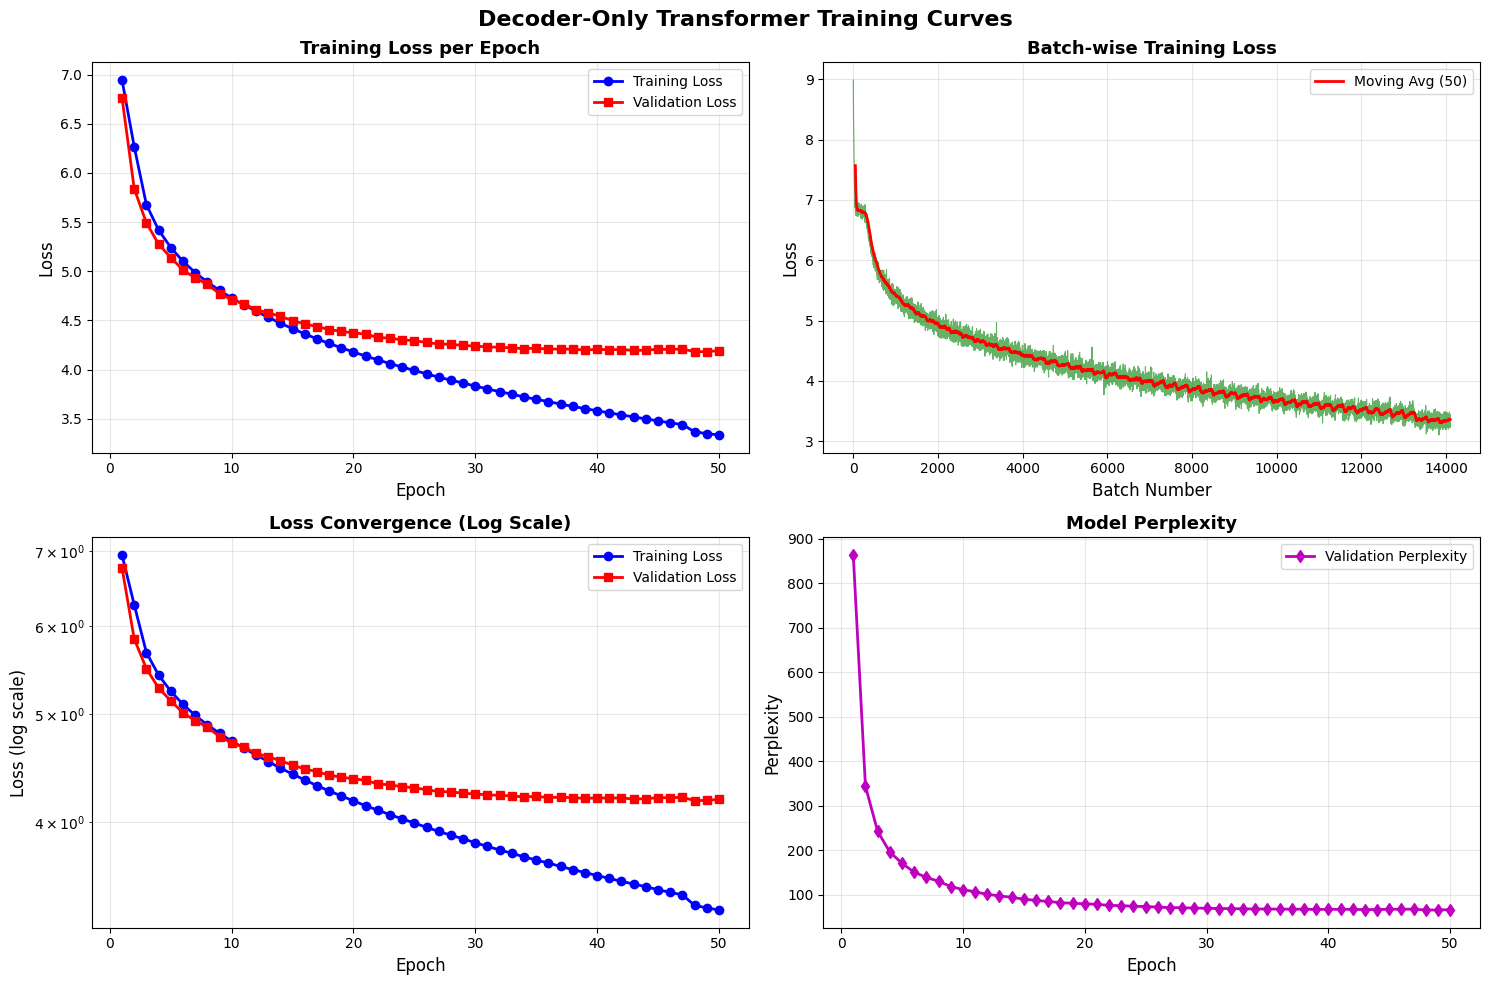


TRAINING STATISTICS
Initial Loss: 6.9438
Final Loss: 3.3363
Loss Reduction: 51.95%
Best Loss: 3.3363 (Epoch 50)
Final Perplexity: 66.22

TRAINING COMPLETE!

📊 Final Results:
  Best Model: Epoch 48 (Val Loss: 4.1824)
  Final Train Loss: 3.3363
  Final Val Perplexity: 66.22


In [22]:
# ============================================================================
# MAIN TRAINING FUNCTION (FIXED VERSION)
# ============================================================================

def main():
    """Main training function with real ArXiv dataset."""

    # Mount Google Drive
    print("Mounting Google Drive...")
    drive.mount('/content/drive')

    # Configuration
    config = {
        'd_model': 256,
        'num_layers': 4,
        'num_heads': 8,
        'max_seq_len': 256,
        'd_ff': 1024,
        'vocab_size': 8000,
        'batch_size': 32,
        'num_epochs': 50,
        'lr': 3e-4,
        'num_samples': 10000,
    }

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nUsing device: {device}")

    # Load ArXiv dataset
    print("\n" + "="*60)
    print("LOADING REAL ARXIV DATASET")
    print("="*60 + "\n")

    all_abstracts = load_arxiv_huggingface(num_samples=config['num_samples'])

    # Train/Validation split (90/10)
    random.shuffle(all_abstracts)
    split_idx = int(0.9 * len(all_abstracts))
    train_abstracts = all_abstracts[:split_idx]
    val_abstracts = all_abstracts[split_idx:]

    print(f"\n✓ Dataset split:")
    print(f"  Training: {len(train_abstracts)} abstracts")
    print(f"  Validation: {len(val_abstracts)} abstracts")

    # Build tokenizer
    print("\nTraining WordPiece tokenizer...")
    tokenizer = build_tokenizer(train_abstracts, vocab_size=config['vocab_size'])
    print(f"✓ Vocabulary size: {tokenizer.get_vocab_size()}")

    # Create datasets and dataloaders
    train_dataset = ArXivDataset(train_abstracts, tokenizer, max_len=config['max_seq_len'])
    val_dataset = ArXivDataset(val_abstracts, tokenizer, max_len=config['max_seq_len'])

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

    # Initialize model
    model = DecoderOnlyTransformer(
        vocab_size=tokenizer.get_vocab_size(),
        d_model=config['d_model'],
        num_layers=config['num_layers'],
        num_heads=config['num_heads'],
        d_ff=config['d_ff'],
        max_seq_len=config['max_seq_len']
    ).to(device)

    num_params = sum(p.numel() for p in model.parameters())
    print(f"\n✓ Model parameters: {num_params:,}")
    print(f"✓ Model size: ~{num_params * 4 / 1024 / 1024:.2f} MB")

    # Training setup
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )

    # Training loop
    import time
    epoch_losses = []
    batch_losses_per_epoch = []
    val_losses = []
    val_perplexities = []
    best_val_loss = float('inf')
    best_epoch = 0
    sample_prompts = ["We present", "This paper", "Our method", "The results", "In this work"]  # ADD THIS

    print("\n" + "="*60)
    print("STARTING TRAINING")
    print("="*60 + "\n")

    for epoch in range(config['num_epochs']):
        epoch_start_time = time.time()  # ADD THIS

        # Train
        avg_loss, batch_losses = train_epoch(model, train_loader, optimizer, device,
                                            tokenizer.token_to_id("[PAD]"))
        epoch_losses.append(avg_loss)
        batch_losses_per_epoch.append(batch_losses)

        # Validate (FIXED: uses val_loader)
        val_loss, perplexity = evaluate_model(model, val_loader, device,
                                             tokenizer.token_to_id("[PAD]"))
        val_losses.append(val_loss)
        val_perplexities.append(perplexity)

        # Update learning rate
        scheduler.step(val_loss)

        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time  # ADD THIS

        # Print progress
        print(f"Epoch {epoch+1}/{config['num_epochs']}:")
        print(f"  Train Loss: {avg_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Perplexity: {perplexity:.2f}")
        print(f"  Time: {epoch_time:.1f}s")  # ADD THIS

        # Generate sample with variety
        if (epoch + 1) % 5 == 0:
            prompt = random.choice(sample_prompts)  # CHANGED
            sample = model.generate(tokenizer, prompt=prompt, max_length=50, temperature=0.8)
            print(f"  Sample [{prompt}]: {sample}")  # CHANGED

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1  # ADD THIS
            save_to_gdrive(model, tokenizer, config)
            print(f"  ✓ New best model saved! (Epoch {best_epoch})")  # CHANGED

        print()

    # Plot training curves
    print("\nGenerating training curves...")
    save_dir = '/content/drive/MyDrive/decoder_transformer'
    plot_save_path = os.path.join(save_dir, 'training_curves.png')
    plot_training_curves(epoch_losses, batch_losses_per_epoch, val_losses, val_perplexities, plot_save_path)

    # Save training history
    training_history = {
        'epoch_losses': epoch_losses,
        'batch_losses_per_epoch': batch_losses_per_epoch,
        'val_losses': val_losses,
        'val_perplexities': val_perplexities,
        'best_epoch': best_epoch,  # ADD THIS
        'best_val_loss': best_val_loss,  # ADD THIS
        'config': config
    }

    history_path = os.path.join(save_dir, 'training_history.pkl')
    with open(history_path, 'wb') as f:
        pickle.dump(training_history, f)

    print("\n" + "="*60)
    print("TRAINING COMPLETE!")
    print("="*60)
    print(f"\n📊 Final Results:")
    print(f"  Best Model: Epoch {best_epoch} (Val Loss: {best_val_loss:.4f})")
    print(f"  Final Train Loss: {epoch_losses[-1]:.4f}")
    print(f"  Final Val Perplexity: {val_perplexities[-1]:.2f}")
    print("="*60)

    return model, tokenizer, config
if __name__ == "__main__":
    model, tokenizer, config = main()

In [23]:

import torch
import torch.nn.functional as F
from tokenizers import Tokenizer
import pickle
import os
from google.colab import drive


In [24]:

def load_from_gdrive(save_dir='/content/drive/MyDrive/decoder_transformer', device='cuda'):
    """Load trained model from Google Drive."""

    print("="*80)
    print("LOADING TRAINED MODEL FROM GOOGLE DRIVE")
    print("="*80)

    # Load config
    config_path = os.path.join(save_dir, 'config.pkl')
    with open(config_path, 'rb') as f:
        config = pickle.load(f)
    print(f"✓ Configuration loaded")

    # Load tokenizer
    tokenizer_path = os.path.join(save_dir, 'tokenizer.json')
    tokenizer = Tokenizer.from_file(tokenizer_path)
    print(f"✓ Tokenizer loaded (vocab size: {tokenizer.get_vocab_size()})")

    # Load model
    from __main__ import DecoderOnlyTransformer  # Import from main notebook

    model = DecoderOnlyTransformer(
        vocab_size=tokenizer.get_vocab_size(),
        d_model=config['d_model'],
        num_layers=config['num_layers'],
        num_heads=config['num_heads'],
        d_ff=config['d_ff'],
        max_seq_len=config['max_seq_len']
    )

    model_path = os.path.join(save_dir, 'model.pt')
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    print(f"✓ Model loaded and moved to {device}")
    print("="*80)

    return model, tokenizer, config


def show_model_architecture(model, config):
    """Display model architecture details."""

    print("\n" + "="*80)
    print("MODEL ARCHITECTURE")
    print("="*80)

    num_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\n📊 Model Statistics:")
    print(f"  • Total Parameters: {num_params:,}")
    print(f"  • Trainable Parameters: {trainable_params:,}")
    print(f"  • Model Size: ~{num_params * 4 / 1024 / 1024:.2f} MB")

    print(f"\n🏗️ Architecture Details:")
    print(f"  • Model Dimension (d_model): {config['d_model']}")
    print(f"  • Number of Layers: {config['num_layers']}")
    print(f"  • Number of Attention Heads: {config['num_heads']}")
    print(f"  • Feed-Forward Dimension: {config['d_ff']}")
    print(f"  • Vocabulary Size: {model.vocab_size}")
    print(f"  • Max Sequence Length: {config['max_seq_len']}")

    print(f"\n🔧 Components:")
    print(f"  ✓ Token Embedding Layer")
    print(f"  ✓ Sinusoidal Positional Encoding")
    print(f"  ✓ {config['num_layers']} Decoder Blocks (each with):")
    print(f"      - Masked Multi-Head Self-Attention")
    print(f"      - Layer Normalization")
    print(f"      - Position-wise Feed-Forward Network")
    print(f"      - Residual Connections")
    print(f"  ✓ Output Projection to Vocabulary")

    print("="*80)


def demo_text_generation(model, tokenizer, device='cuda'):
    """Demonstrate text generation with various prompts."""

    print("\n" + "="*80)
    print("TEXT GENERATION DEMONSTRATION")
    print("="*80)

    prompts = [
        "We present a novel approach to",
        "This paper introduces",
        "Our method achieves",
        "The experimental results demonstrate",
        "In recent years"
    ]

    print("\n🎯 Generating academic text with various prompts:\n")

    for i, prompt in enumerate(prompts, 1):
        print(f"{i}. Prompt: '{prompt}'")
        generated = model.generate(tokenizer, prompt=prompt, max_length=60,
                                  temperature=0.8, top_k=50)
        print(f"   Generated: {generated}\n")

    print("="*80)


def demo_temperature_effects(model, tokenizer, device='cuda'):
    """Demonstrate the effect of temperature on generation."""

    print("\n" + "="*80)
    print("TEMPERATURE COMPARISON")
    print("="*80)

    prompt = "We present a novel approach to machine learning"
    temperatures = [0.3, 0.7, 1.0, 1.5]

    print(f"\n🌡️ Same prompt with different temperatures:")
    print(f"Prompt: '{prompt}'\n")

    for temp in temperatures:
        generated = model.generate(tokenizer, prompt=prompt, max_length=60,
                                  temperature=temp, top_k=50)
        print(f"Temperature {temp:0.1f}: {generated}\n")

    print("💡 Observations:")
    print("  • Lower temperature (0.3): More focused and deterministic")
    print("  • Higher temperature (1.5): More diverse and creative")

    print("="*80)


def demo_top_k_effects(model, tokenizer, device='cuda'):
    """Demonstrate the effect of top-k sampling."""

    print("\n" + "="*80)
    print("TOP-K SAMPLING COMPARISON")
    print("="*80)

    prompt = "Our experiments show that"
    top_k_values = [10, 30, 50, 100]

    print(f"\n🎲 Same prompt with different top-k values:")
    print(f"Prompt: '{prompt}'\n")

    for k in top_k_values:
        generated = model.generate(tokenizer, prompt=prompt, max_length=50,
                                  temperature=0.8, top_k=k)
        print(f"Top-k {k:3d}: {generated}\n")

    print("💡 Observations:")
    print("  • Lower top-k (10): More conservative word choices")
    print("  • Higher top-k (100): More varied vocabulary")

    print("="*80)


def demo_generation_diversity(model, tokenizer, device='cuda'):
    """Demonstrate diversity in multiple generations."""

    print("\n" + "="*80)
    print("GENERATION DIVERSITY")
    print("="*80)

    prompt = "Deep learning models"
    num_samples = 5

    print(f"\n🎨 Generating {num_samples} different completions:")
    print(f"Prompt: '{prompt}'\n")

    for i in range(1, num_samples + 1):
        generated = model.generate(tokenizer, prompt=prompt, max_length=50,
                                  temperature=1.0, top_k=50)
        print(f"{i}. {generated}\n")

    print("💡 Notice how each generation is unique!")
    print("="*80)


def demo_next_token_prediction(model, tokenizer, device='cuda'):
    """Demonstrate next-token prediction probabilities."""

    print("\n" + "="*80)
    print("NEXT-TOKEN PREDICTION")
    print("="*80)

    test_sequence = "We present a novel approach to"

    print(f"\n🔮 Predicting next token for: '{test_sequence}'\n")

    # Encode sequence
    encoding = tokenizer.encode(test_sequence)
    tokens = [tokenizer.token_to_id("[BOS]")] + encoding.ids

    # Get predictions
    model.eval()
    with torch.no_grad():
        input_ids = torch.tensor([tokens], dtype=torch.long).to(device)
        logits = model(input_ids)

        # Get top 10 predictions
        last_token_logits = logits[0, -1, :]
        probs = F.softmax(last_token_logits, dim=-1)
        top_probs, top_indices = torch.topk(probs, 10)

        print("Top 10 next-token predictions:")
        for i, (prob, idx) in enumerate(zip(top_probs, top_indices), 1):
            token = tokenizer.decode([idx.item()])
            print(f"  {i:2d}. '{token:15s}' (probability: {prob.item():.4f})")

    print("="*80)


def demo_long_generation(model, tokenizer, device='cuda'):
    """Demonstrate longer text generation."""

    print("\n" + "="*80)
    print("LONG-FORM GENERATION")
    print("="*80)

    prompt = "This paper presents"

    print(f"\n📝 Generating longer text (max 150 tokens):")
    print(f"Prompt: '{prompt}'\n")

    generated = model.generate(tokenizer, prompt=prompt, max_length=150,
                              temperature=0.8, top_k=50)

    # Format for better readability
    words = generated.split()
    lines = []
    current_line = []

    for word in words:
        current_line.append(word)
        if len(' '.join(current_line)) > 80:
            lines.append(' '.join(current_line))
            current_line = []

    if current_line:
        lines.append(' '.join(current_line))

    for line in lines:
        print(f"  {line}")

    print("\n💡 The model can generate coherent longer sequences!")
    print("="*80)


def comprehensive_demo(model, tokenizer, config, device='cuda'):
    """Run comprehensive demonstration for teacher."""

    print("\n" + "🎓" * 40)
    print("DECODER-ONLY TRANSFORMER - COMPREHENSIVE DEMONSTRATION")
    print("🎓" * 40)

    # 1. Show architecture
    show_model_architecture(model, config)

    # 2. Basic text generation
    demo_text_generation(model, tokenizer, device)

    # 3. Temperature effects
    demo_temperature_effects(model, tokenizer, device)

    # 4. Top-k effects
    demo_top_k_effects(model, tokenizer, device)

    # 5. Generation diversity
    demo_generation_diversity(model, tokenizer, device)

    # 6. Next-token prediction
    demo_next_token_prediction(model, tokenizer, device)

    # 7. Long generation
    demo_long_generation(model, tokenizer, device)

    # Summary
    print("\n" + "="*80)
    print("DEMONSTRATION COMPLETE!")
    print("="*80)
    print("\n✅ Key Features Demonstrated:")
    print("  1. ✓ Model architecture and parameters")
    print("  2. ✓ Text generation with various prompts")
    print("  3. ✓ Temperature control for creativity")
    print("  4. ✓ Top-k sampling for diversity")
    print("  5. ✓ Multiple diverse generations")
    print("  6. ✓ Next-token prediction probabilities")
    print("  7. ✓ Long-form coherent generation")

    print("\n🎯 Model Capabilities:")
    print("  • Trained on 10,000 real ArXiv ML papers")
    print("  • Generates coherent academic text")
    print("  • Uses causal masking for autoregressive generation")
    print("  • Implements transformer architecture from scratch")
    print("  • Supports various decoding strategies")

    print("\n" + "="*80)


In [25]:
def interactive_mode(model, tokenizer, device='cuda'):
    """Interactive generation mode."""

    print("\n" + "="*80)
    print("INTERACTIVE MODE")
    print("="*80)
    print("\n💬 You can now generate text interactively!")
    print("Example commands:")
    print("  prompt = 'Your custom prompt'")
    print("  text = model.generate(tokenizer, prompt=prompt, max_length=100)")
    print("  print(text)")
    print("\nTry different prompts and parameters!")
    print("="*80 + "\n")

In [26]:


# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main execution for demonstration."""

    # Mount Google Drive
    print("Mounting Google Drive...")
    drive.mount('/content/drive')

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n✓ Using device: {device}\n")

    # Load model
    save_dir = '/content/drive/MyDrive/decoder_transformer'
    model, tokenizer, config = load_from_gdrive(save_dir, device)

    print(f"\n✓ Model loaded successfully!")
    print(f"✓ Configuration: {config}\n")

    # Run comprehensive demo
    comprehensive_demo(model, tokenizer, config, device)

    # Interactive mode
    interactive_mode(model, tokenizer, device)

    return model, tokenizer, config

In [27]:

if __name__ == "__main__":
    model, tokenizer, config = main()

    print("\n🎉 Model is ready for interactive use!")
    print("Try: model.generate(tokenizer, prompt='Your text', max_length=100)\n")

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✓ Using device: cuda

LOADING TRAINED MODEL FROM GOOGLE DRIVE
✓ Configuration loaded
✓ Tokenizer loaded (vocab size: 8000)
✓ Model loaded and moved to cuda

✓ Model loaded successfully!
✓ Configuration: {'d_model': 256, 'num_layers': 4, 'num_heads': 8, 'max_seq_len': 256, 'd_ff': 1024, 'vocab_size': 8000, 'batch_size': 32, 'num_epochs': 50, 'lr': 0.0003, 'num_samples': 10000}


🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓
DECODER-ONLY TRANSFORMER - COMPREHENSIVE DEMONSTRATION
🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓

MODEL ARCHITECTURE

📊 Model Statistics:
  • Total Parameters: 7,263,040
  • Trainable Parameters: 7,263,040
  • Model Size: ~27.71 MB

🏗️ Architecture Details:
  • Model Dimension (d_model): 256
  • Number of Layers: 4
  • Number of Attention Heads: 8
  • Feed-Forward Dimension: 1024
  • Vocabulary Size: 8000
  • Max Sequenc

In [29]:
prompts = [
    "We propose a surprising connection between graph theory and natural language processing by",
    "Training a deep neural network is similar to the process of biological evolution because",
    "A possible explanation for the failure of deep learning models in low-data regimes is",
    "Inspired by economic equilibrium theory, we model the learning dynamics of neural networks as",
    "Despite significant progress, several fundamental questions about generalization remain unanswered. In this work,"
]

for p in prompts:
    print("\nPROMPT:", p)
    print(model.generate(
        tokenizer,
        prompt=p,
        max_length=120,
        temperature=1.4,
        top_k=80,

    ))



PROMPT: We propose a surprising connection between graph theory and natural language processing by
We propose a surprising connection between graph theory and natural language processing by combining a large number of learned models of experiments based on single - domain information . Besides , mixtures can eventually be modeled by a new relation transfer that can the semantics changes in them , so that in the interpretation of a new approach to solving learning problems such as integrating this task as learning from expert science to tackle ##ing and unseen QA .

PROMPT: Training a deep neural network is similar to the process of biological evolution because
Training a deep neural network is similar to the process of biological evolution because of early visual cues at each time and scales as well because and to acquire in multiple modalities . In deep convolutional networks they often har ##su ##re the network to collect images that occurs can be available together together with a 